In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

Dataset: Ahmed, M. (2020). Maternal Health Risk [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5DP5D.

In [31]:
df = pd.read_csv('sample_data.csv')

Exploratory Data Analysis

In [32]:
df.isna().sum().sum() # how many missing values do we have?

np.int64(0)

In [33]:
d = {"low risk": 0, "mid risk": 1, "high risk": 2}
df["RiskLevel"] = df["RiskLevel"].str.strip().str.lower().map(d)

In [34]:
features = ["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp", "HeartRate"]
features_X = df[features]
target_y = df["RiskLevel"]

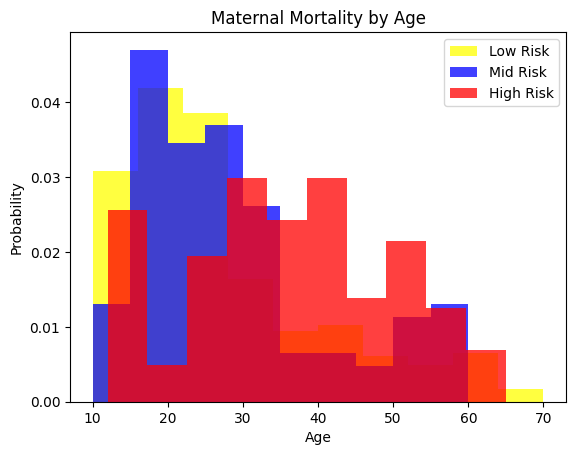

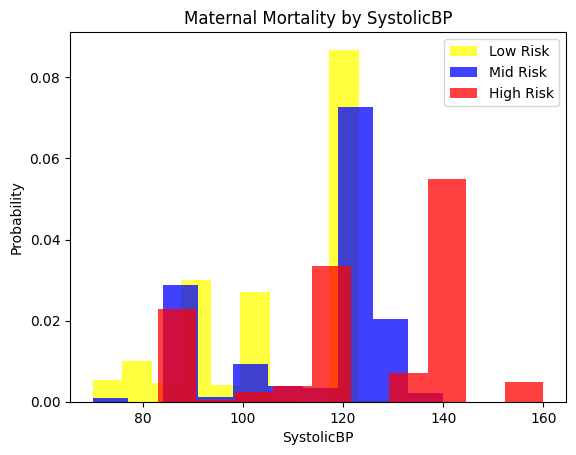

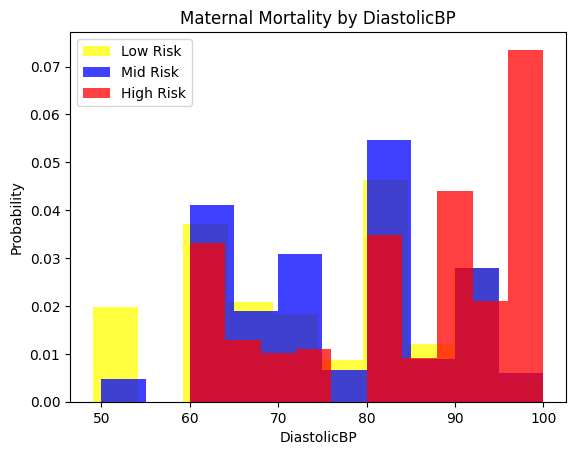

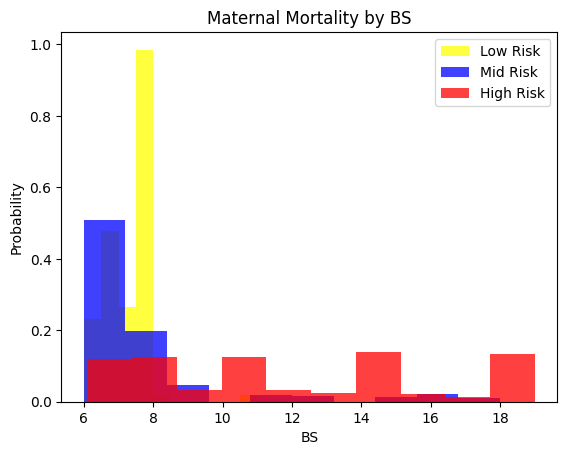

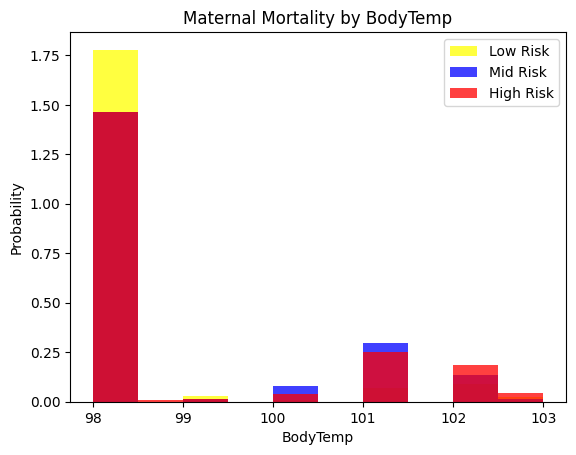

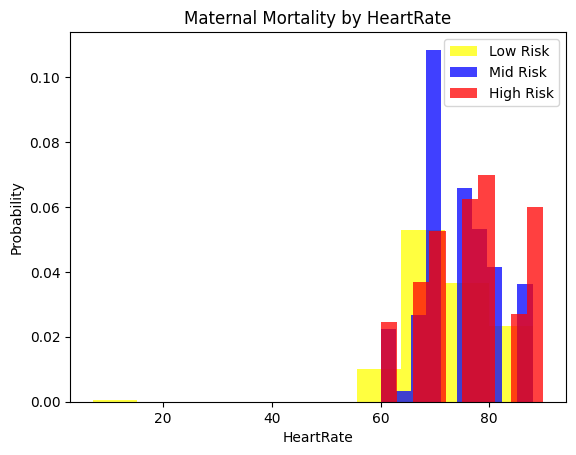

In [35]:
for feature in features:
    plt.hist(df[target_y == 0][feature], color="yellow", label="Low Risk", alpha=0.75, density=True)
    plt.hist(df[target_y == 1][feature], color="blue", label="Mid Risk", alpha=0.75, density=True)
    plt.hist(df[target_y == 2][feature], color="red", label="High Risk", alpha=0.75, density=True)
    plt.title(f"Maternal Mortality by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Probability")
    plt.legend()
    plt.show()

In [36]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Utilizing GridSearchCV to determine the best model and hyperparameters for the dataset

In [37]:
models = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [1, 10, 20],
            'decision_function_shape': ['ovo', 'ovr'],
            'kernel': ['linear', 'poly', 'rbf']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(solver='lbfgs'),
        'params': {
            'C': [1, 10, 20],
            'max_iter': [200, 500, 1000]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [1000, 1500, 2000],
            'max_depth': [35, 50, 100]
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {}
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [10, 20, 40],
            'splitter': ['best', 'random'],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 5, 10]
        }
    },
    'KNearestNeighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1,5,10],
        }
    }
}

In [38]:
scores = []

for name, config in models.items():
    
    pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ros', RandomOverSampler()), # applied only during training
    ('model', config['model'])
    ])

    param_grid = {
        f'model__{k}': v for k, v in config['params'].items()
    }

    gscv = GridSearchCV(pipe, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    gscv.fit(X_train, y_train)
    
    best_pipe = gscv.best_estimator_
    test_score = best_pipe.score(X_test, y_test)

    scores.append({
        'model': name,
        'cv_score': gscv.best_score_,
        'test_score': test_score,
        'best_params': gscv.best_params_ 
    })

df2 = pd.DataFrame(scores, columns=['model', 'cv_score', 'test_score', 'best_params'])
df2

,model,cv_score,test_score,best_params
0,SVM,0.717907,0.668852,"{'model__C': 1, 'model__decision_function_shap..."
1,LogisticRegression,0.627646,0.629508,"{'model__C': 10, 'model__max_iter': 200}"
2,RandomForest,0.819517,0.809836,"{'model__max_depth': 50, 'model__n_estimators'..."
3,GaussianNB,0.636177,0.600000,{}
4,DecisionTree,0.815252,0.822951,"{'model__max_depth': 40, 'model__min_samples_l..."
5,KNearestNeighbors,0.801207,0.809836,{'model__n_neighbors': 1}


In [39]:
max(df2['test_score'])

0.8229508196721311

In [40]:
df2.loc[df2['test_score'].idxmax(), 'best_params']

{'model__max_depth': 40,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__splitter': 'best'}

Searching for the best hyperparamters for a Neural Network, and checking if it has better results than the classical models.

In [41]:
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)

In [42]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.show()

l1_nodes: 32, l2_nodes: 32, dropout_prob: 0, learning_rate: 0.01, batch_size: 32


c:\Users\ifrai\maternal-mortality-predictor\venv\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


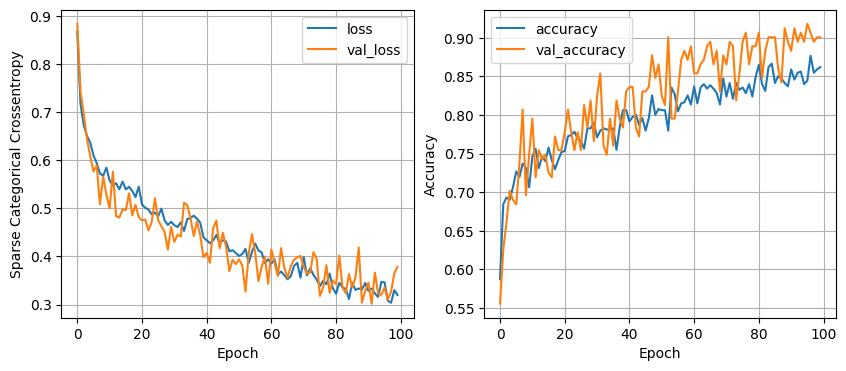

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7115 - loss: 0.8323 
l1_nodes: 32, l2_nodes: 32, dropout_prob: 0, learning_rate: 0.01, batch_size: 50


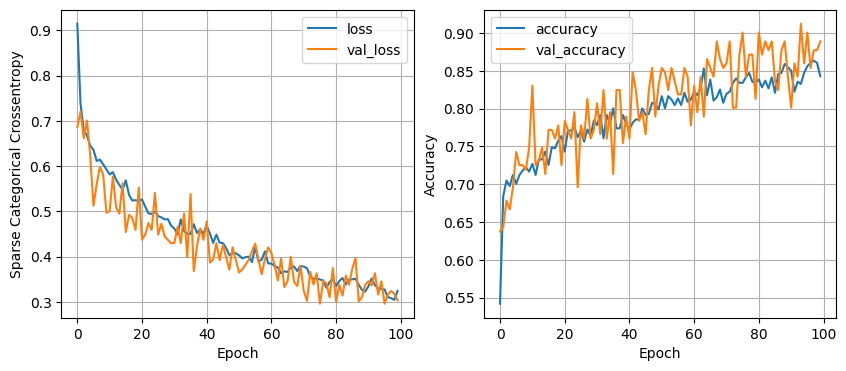

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7410 - loss: 0.8301 
l1_nodes: 32, l2_nodes: 32, dropout_prob: 0, learning_rate: 0.005, batch_size: 32


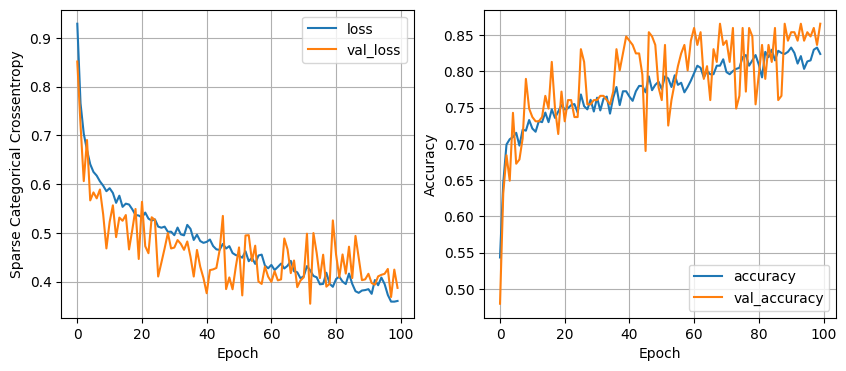

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7049 - loss: 0.8345 
l1_nodes: 32, l2_nodes: 32, dropout_prob: 0, learning_rate: 0.005, batch_size: 50


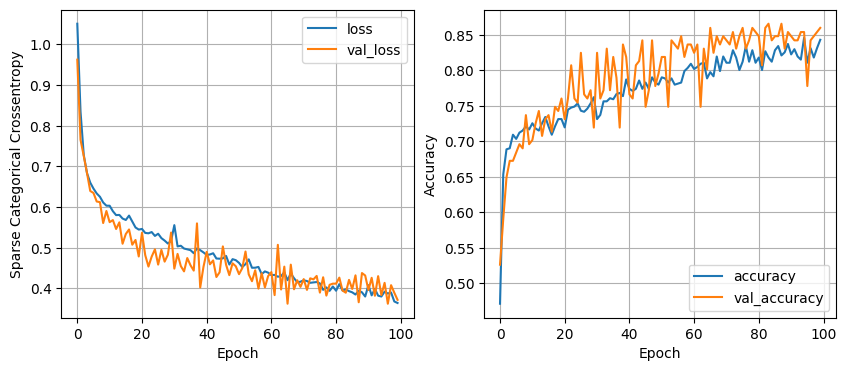

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6918 - loss: 0.7455 
l1_nodes: 32, l2_nodes: 64, dropout_prob: 0, learning_rate: 0.01, batch_size: 32


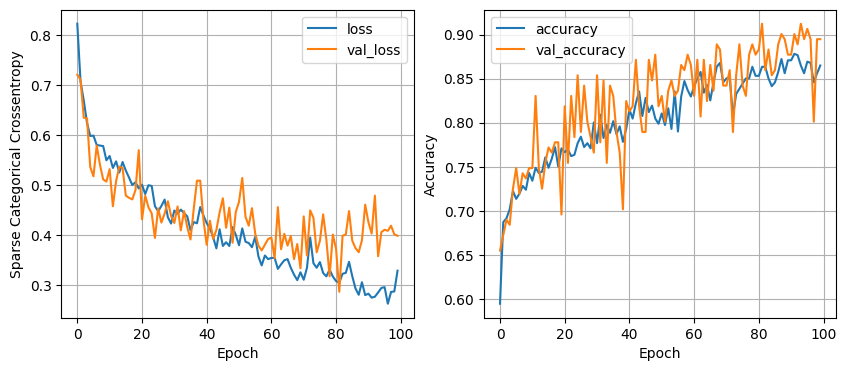

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7344 - loss: 1.0897 
l1_nodes: 32, l2_nodes: 64, dropout_prob: 0, learning_rate: 0.01, batch_size: 50


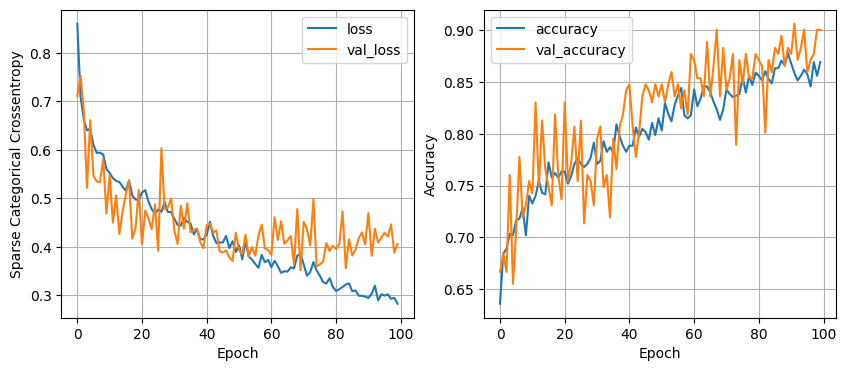

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7475 - loss: 0.9071 
l1_nodes: 32, l2_nodes: 64, dropout_prob: 0, learning_rate: 0.005, batch_size: 32


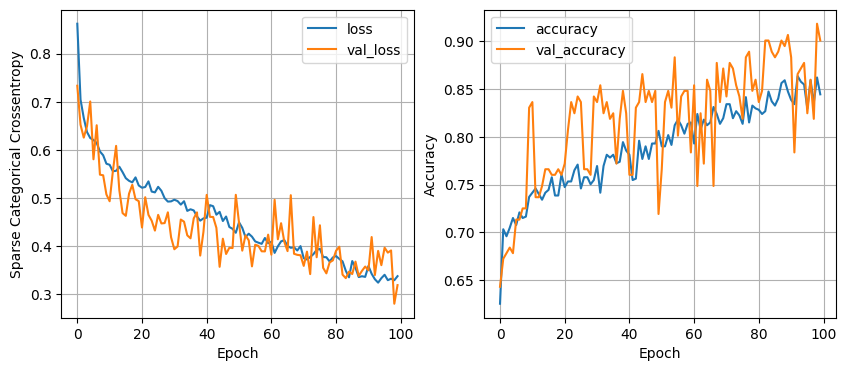

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7148 - loss: 0.8360  
l1_nodes: 32, l2_nodes: 64, dropout_prob: 0, learning_rate: 0.005, batch_size: 50


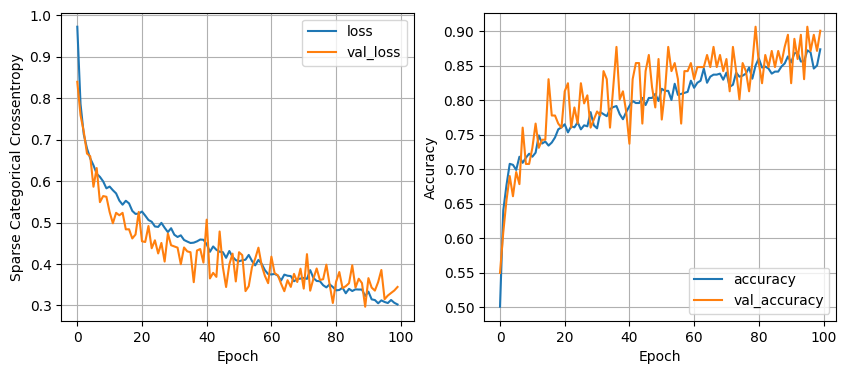

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7082 - loss: 0.8271 
l1_nodes: 64, l2_nodes: 32, dropout_prob: 0, learning_rate: 0.01, batch_size: 32


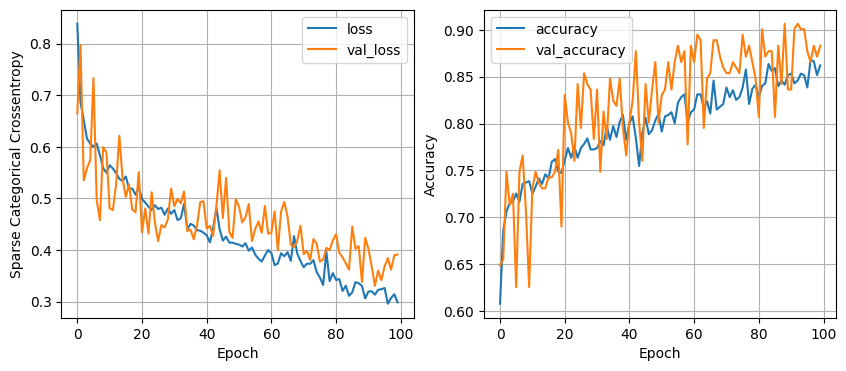

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7311 - loss: 0.8941 
l1_nodes: 64, l2_nodes: 32, dropout_prob: 0, learning_rate: 0.01, batch_size: 50


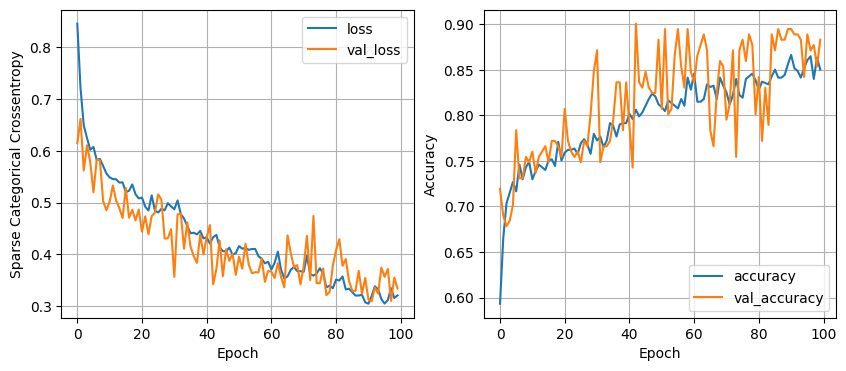

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7180 - loss: 0.7849 
l1_nodes: 64, l2_nodes: 32, dropout_prob: 0, learning_rate: 0.005, batch_size: 32


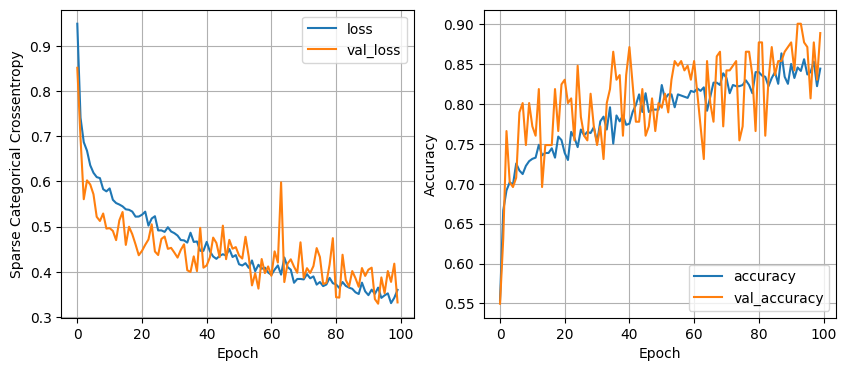

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6689 - loss: 0.8328 
l1_nodes: 64, l2_nodes: 32, dropout_prob: 0, learning_rate: 0.005, batch_size: 50


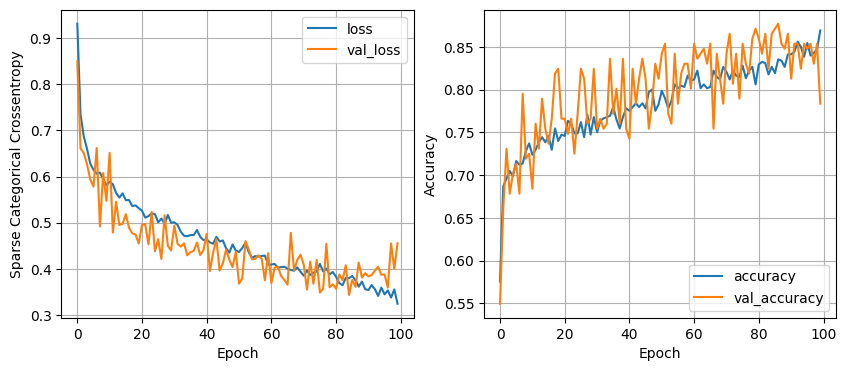

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6951 - loss: 0.7647 
l1_nodes: 64, l2_nodes: 64, dropout_prob: 0, learning_rate: 0.01, batch_size: 32


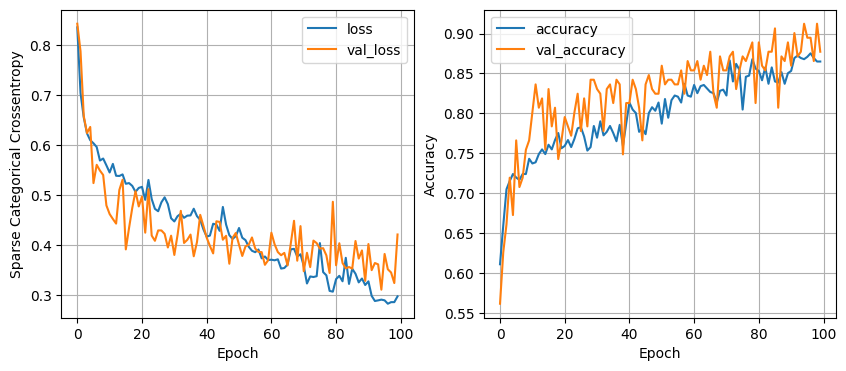

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7410 - loss: 0.8152 
l1_nodes: 64, l2_nodes: 64, dropout_prob: 0, learning_rate: 0.01, batch_size: 50


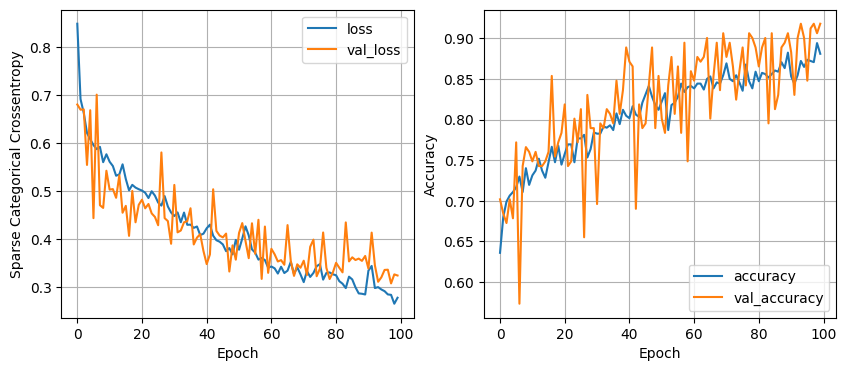

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7377 - loss: 0.8963 
l1_nodes: 64, l2_nodes: 64, dropout_prob: 0, learning_rate: 0.005, batch_size: 32


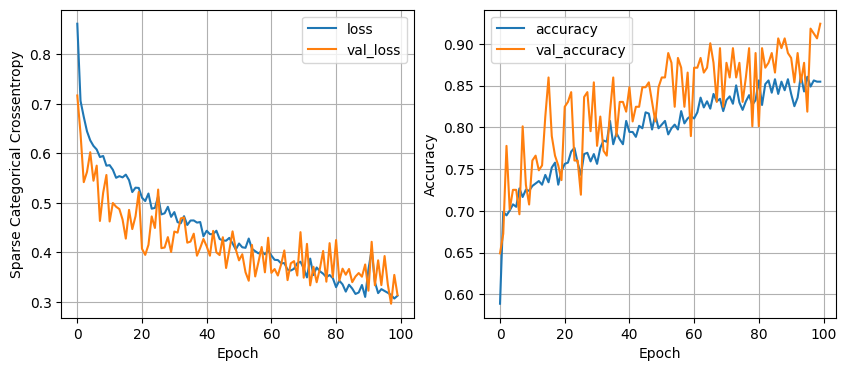

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7246 - loss: 0.8161
l1_nodes: 64, l2_nodes: 64, dropout_prob: 0, learning_rate: 0.005, batch_size: 50


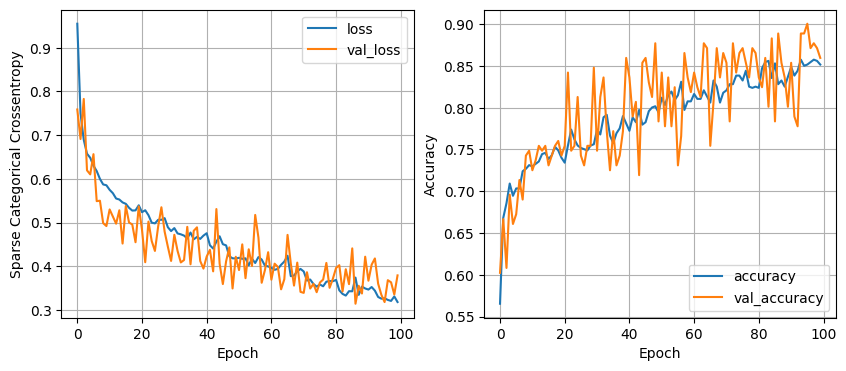

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6918 - loss: 0.7925 


In [43]:
def train_model(X_train, y_train, l1_nodes, l2_nodes, dropout_prob, learning_rate, epochs, batch_size):
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=l1_nodes, activation='relu', input_shape=(6,)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(units=l2_nodes, activation='relu'), 
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(units=3, activation='softmax')
    ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  
    history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    
    return nn_model, history

most_val_accuracy = 0
most_accuracy_model = None
epochs = 100

for l1_nodes in [32, 64]:
    for l2_nodes in [32, 64]:
        for dropout_prob in [0]:
            for learning_rate in [0.01, 0.005]:
                for batch_size in [32, 50]:
                    print(f"l1_nodes: {l1_nodes}, l2_nodes: {l2_nodes}, dropout_prob: {dropout_prob}, learning_rate: {learning_rate}, batch_size: {batch_size}")
                    model, history = train_model(X_train, y_train, l1_nodes, l2_nodes, dropout_prob, learning_rate, epochs, batch_size)
                    plot_history(history)
                    val_accuracy = model.evaluate(X_test, y_test)[1]
                    if val_accuracy > most_val_accuracy:
                        most_val_accuracy = val_accuracy
                        most_accuracy_model = model 

In [44]:
print("Final training accuracy:", history.history['accuracy'][-1])
print("Final validation accuracy:", history.history['val_accuracy'][-1])
test_loss, test_acc = most_accuracy_model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy:", test_acc)

Final training accuracy: 0.8516886830329895
Final validation accuracy: 0.859649121761322
Test accuracy: 0.7475410103797913


In [50]:
y_pred_probs = most_accuracy_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       122
           1       0.64      0.65      0.65       101
           2       0.88      0.88      0.88        82

    accuracy                           0.75       305
   macro avg       0.76      0.76      0.76       305
weighted avg       0.75      0.75      0.75       305

[[90 31  1]
 [26 66  9]
 [ 4  6 72]]


Conclusion: RandomForest is the best model for this dataset.

In [49]:
rf_final = RandomForestClassifier(
    max_depth=35,
    n_estimators=1000,
)

rf_final.fit(X_train, y_train)
y_test_pred = rf_final.predict(X_test)

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.74      0.81      0.78       122
           1       0.70      0.64      0.67       101
           2       0.91      0.88      0.89        82

    accuracy                           0.77       305
   macro avg       0.78      0.78      0.78       305
weighted avg       0.77      0.77      0.77       305

[[94 25  3]
 [33 63  5]
 [ 3 14 65]]
